# []

In [1]:
# inbuilt 
import os
import sys
import math

# most common
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch as tt
import torch.nn as nn
import torch.optim as oo
import torch.functional as ff
import torch.distributions as dd
import torch.utils.data as ud

# custom
import known
import known.ktorch as kt

print(f'{sys.version=}\n{np.__version__=}\n{tt.__version__=}\n{known.__version__=}')

sys.version='3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]'
np.__version__='1.24.1'
tt.__version__='1.13.1+cpu'
known.__version__='0.0.1'


In [2]:
def gen(rng, n, d):
    x=np.linspace(0, 10*np.pi, n)
    if d==0:
        y = 10*np.sin(x)
    elif d==1:
        y = -5*np.cos(x)
    elif d==2:
        y = 7*np.sin(x) + -9*np.cos(x)
    else:
        print('invalid dim')
    return y

kt.SeqDataset.generate(
    genF=gen,
    genS=1000,
    colS=['a', 'b', 'c'], normalize=False, file_name='train.csv'
)

,a,b,c
0,0.000000e+00,-5.000000,-9.000000
1,3.144219e-01,-4.997528,-8.775455
2,6.285329e-01,-4.990114,-8.542232
3,9.420224e-01,-4.977765,-8.300562
4,1.254580e+00,-4.960495,-8.050684
...,...,...,...
995,-1.254580e+00,-4.960495,-9.807097
996,-9.420224e-01,-4.977765,-9.619393
997,-6.285329e-01,-4.990114,-9.422178
998,-3.144219e-01,-4.997528,-9.215645


In [3]:
seqlen = 5
cols = ('a', 'b', 'c')
input_size = len(cols)
ds = kt.SeqDataset.from_csv('train.csv', cols=cols, seqlen=seqlen, reverse=True, normalize=False, squeeze_label=True, dtype=tt.float32)
ds

In [4]:
class RnnMlp(nn.Module):
    def __init__(self, rnn_class) -> None:
        super().__init__()
        self.rnn_class = rnn_class
        rnnargs = dict(
            input_size=input_size, hidden_sizes=(8, 8, 8), actF=tt.tanh, batch_first=True, dtype=tt.float32
        )
        if rnn_class is kt.ELMAN or rnn_class is kt.GRU or rnn_class is kt.MGU: 
            self.rnn = rnn_class(True, False, **rnnargs)
        elif rnn_class is kt.JANET:
            rnnargs['beta']=0.0
            self.rnn = rnn_class(True, False, **rnnargs)
        elif rnn_class is kt.LSTM:
            rnnargs['actC']=tt.tanh
            self.rnn = rnn_class(True, False, **rnnargs)
        elif rnn_class is nn.RNN or rnn_class is nn.GRU or rnn_class is nn.LSTM:
            self.rnn = rnn_class(input_size=input_size, hidden_size=8, num_layers=3, batch_first=True)
        else:
            print('Invalid_RNN_Class')
            
        
        self.fc = nn.Sequential( nn.Flatten(), nn.Linear(8, input_size))
        #self.fc = nn.Flatten()

    def forward(self, X):
        x, *_ = self.rnn(X)
        #y = self.fc(x[-1])
        return self.fc(x[:, -1, :])

rnms = [    RnnMlp(kt.ELMAN),   RnnMlp(kt.GRU),     RnnMlp(kt.JANET),   RnnMlp(kt.MGU),     RnnMlp(kt.LSTM), 
            RnnMlp(nn.RNN),     RnnMlp(nn.GRU),     RnnMlp(nn.LSTM)     ]
rnmc = [    'tab:blue',         'tab:red',          'tab:green',        'tab:brown',       'tab:olive',
            'tab:pink',         'tab:orange',        'tab:grey'          ]

In [5]:
dl = ds.dataloader(batch_size=2)
dli = iter(dl)
x,y = next(dli)
with tt.no_grad():
    h = rnms[0](x)
x.shape, y.shape, h.shape

(torch.Size([2, 5, 3]), torch.Size([2, 3]), torch.Size([2, 3]))

<class 'known.ktorch.rnn.ELMAN'>
Start Training @ 2023-01-10 03:33:25.765219
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [8.041860837693093e-05]
Final Validation Loss: [9.713353938423097e-05]
End Training @ 2023-01-10 03:34:19.558749, Elapsed Time: [0:00:53.793530]


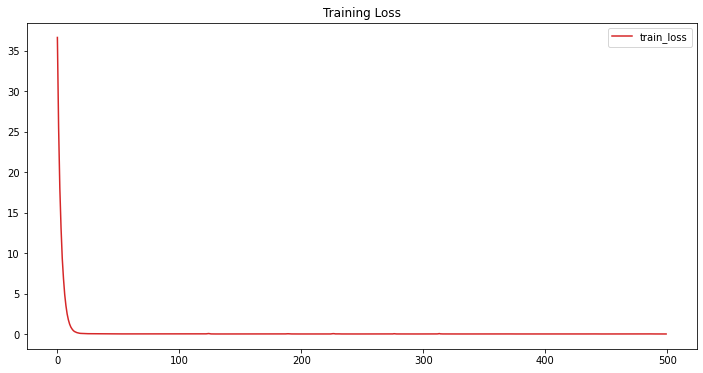

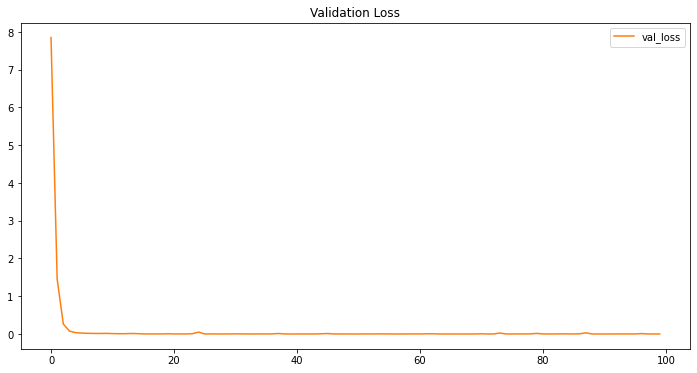

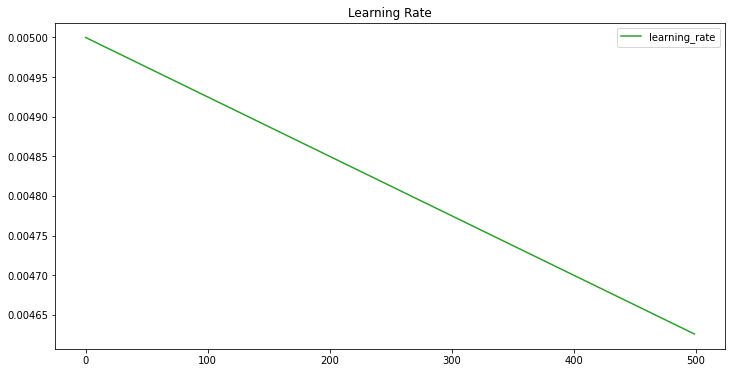

<class 'known.ktorch.rnn.GRU'>
Start Training @ 2023-01-10 03:34:19.865780
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [0.00018171873807659722]
Final Validation Loss: [0.0003677874628920108]
End Training @ 2023-01-10 03:36:45.539402, Elapsed Time: [0:02:25.673622]


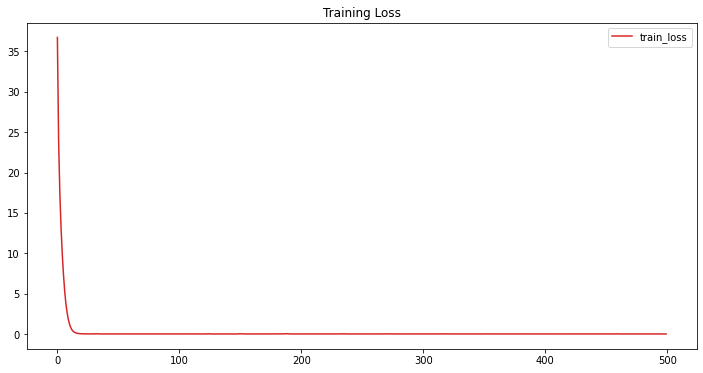

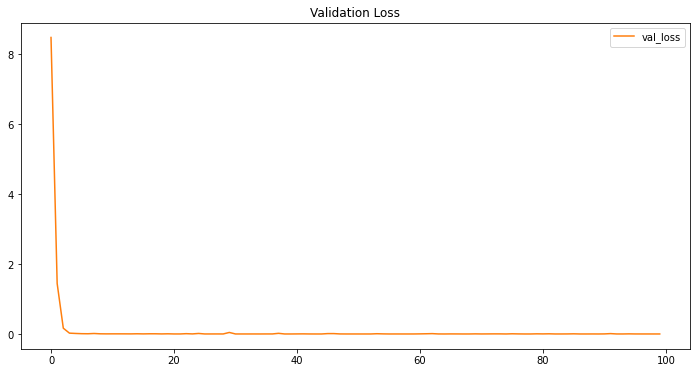

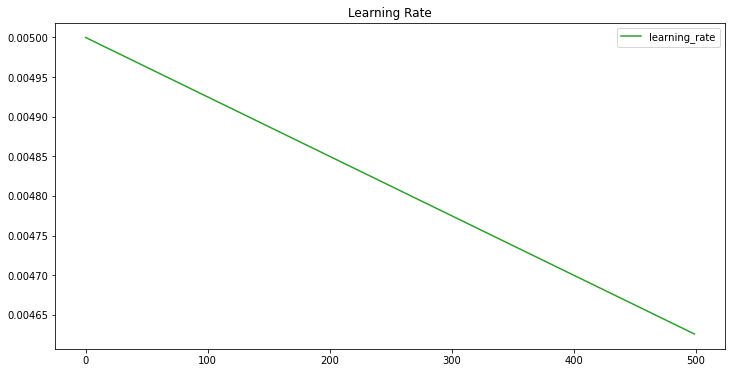

<class 'known.ktorch.rnn.JANET'>
Start Training @ 2023-01-10 03:36:45.809432
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [0.003072117873671232]
Final Validation Loss: [0.0017999777337536216]
End Training @ 2023-01-10 03:38:37.493472, Elapsed Time: [0:01:51.684040]


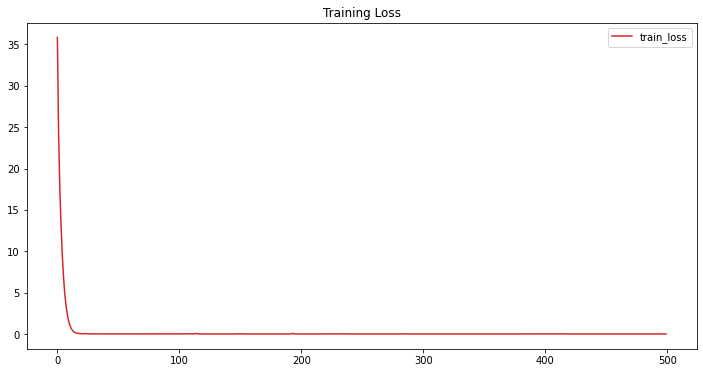

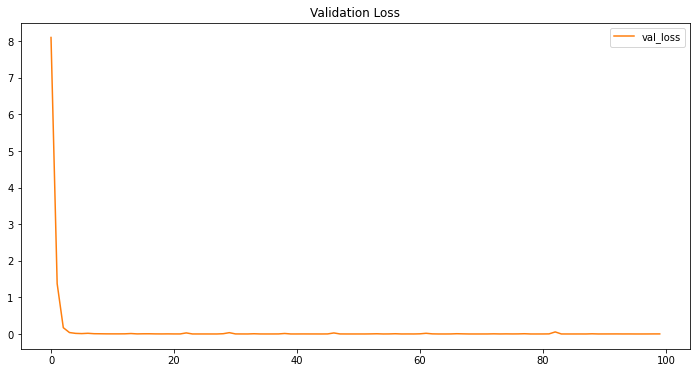

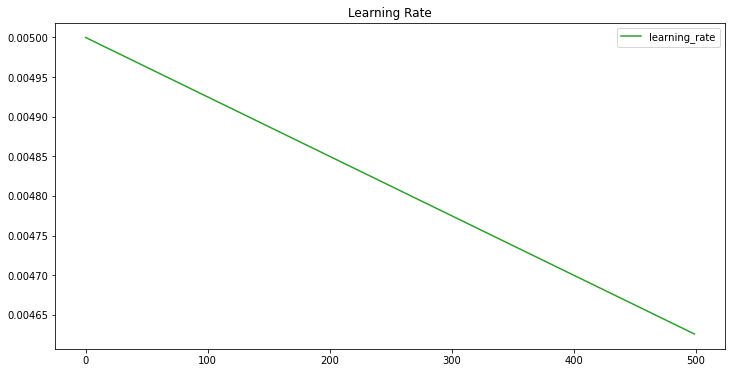

<class 'known.ktorch.rnn.MGU'>
Start Training @ 2023-01-10 03:38:37.780483
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [5.455531368170341e-05]
Final Validation Loss: [8.485127182211727e-05]
End Training @ 2023-01-10 03:40:27.503045, Elapsed Time: [0:01:49.722562]


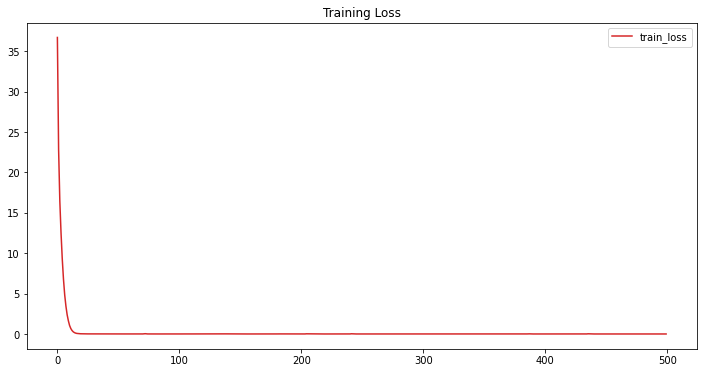

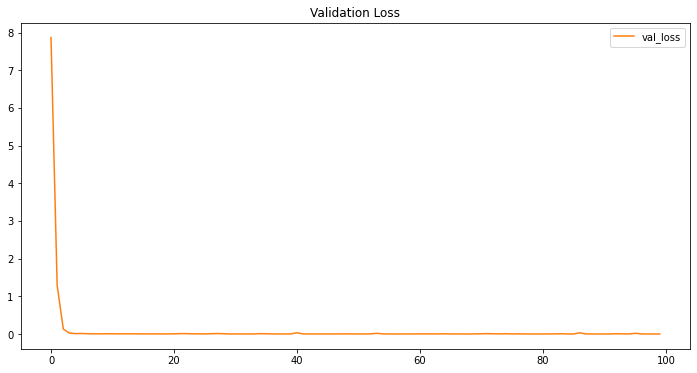

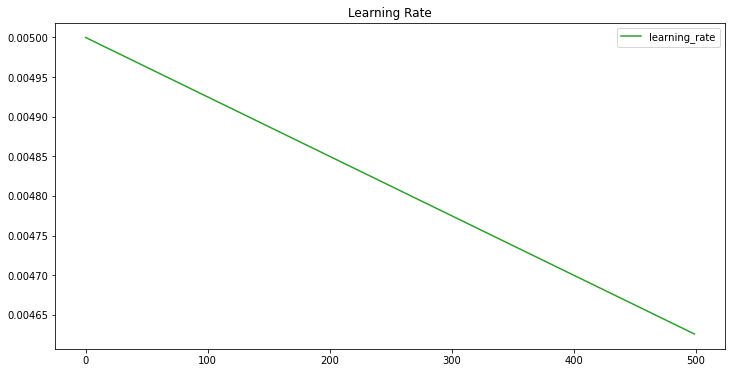

<class 'known.ktorch.rnn.LSTM'>
Start Training @ 2023-01-10 03:40:27.794464
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [0.0021047866666776827]
Final Validation Loss: [0.009020145982503891]
End Training @ 2023-01-10 03:43:27.841734, Elapsed Time: [0:03:00.047270]


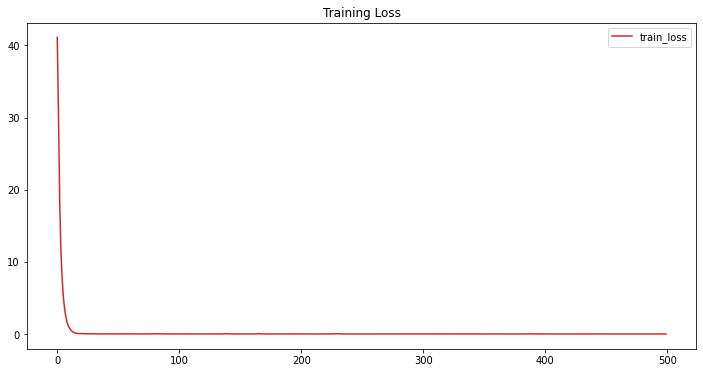

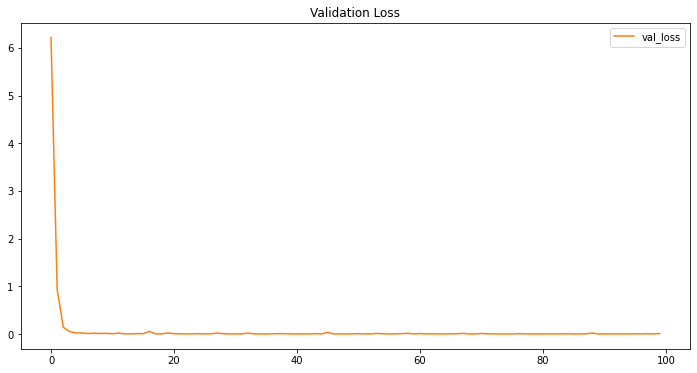

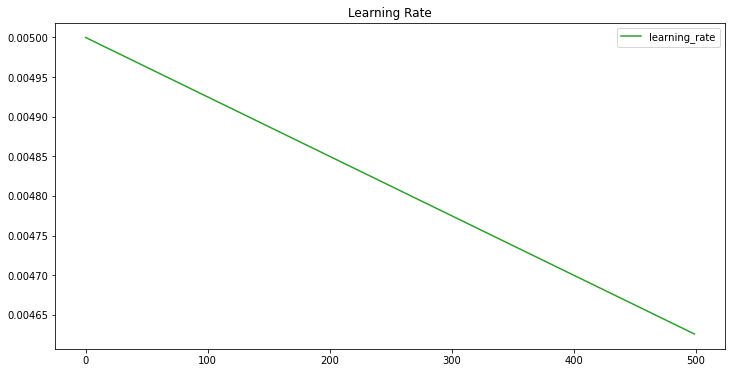

<class 'torch.nn.modules.rnn.RNN'>
Start Training @ 2023-01-10 03:43:28.161752
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [0.0013185231682655285]
Final Validation Loss: [0.0016052464488893747]
End Training @ 2023-01-10 03:44:15.932114, Elapsed Time: [0:00:47.770362]


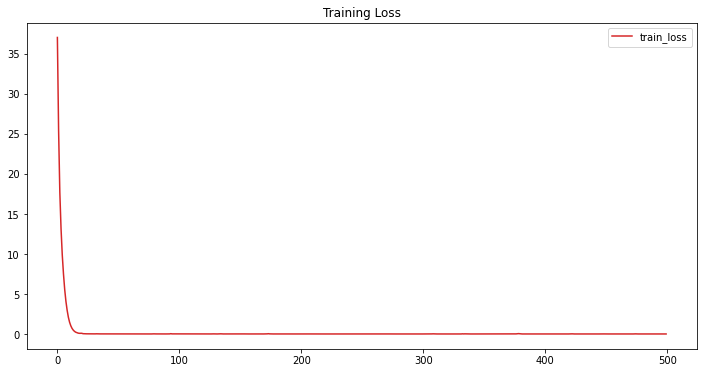

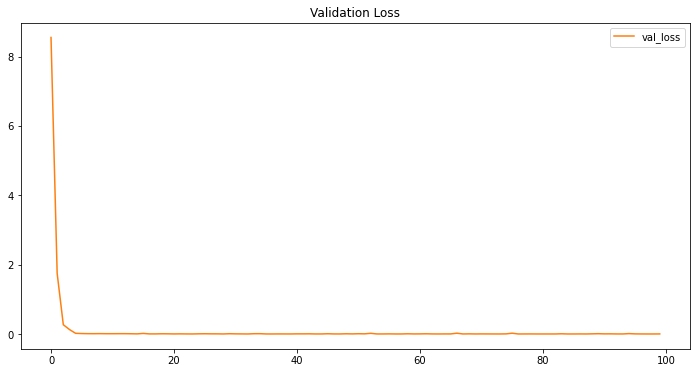

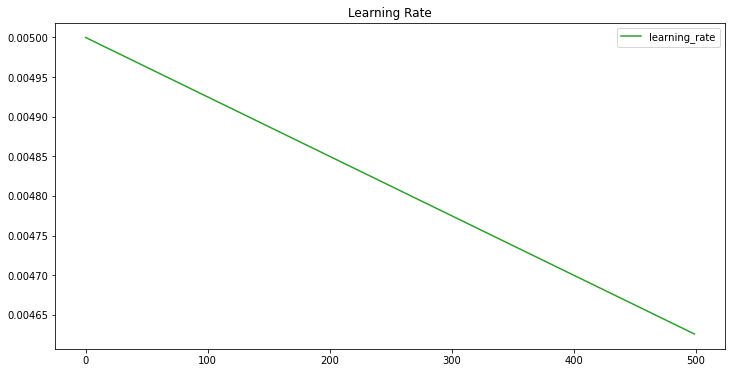

<class 'torch.nn.modules.rnn.GRU'>
Start Training @ 2023-01-10 03:44:16.195116
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [0.0009644400906836381]
Final Validation Loss: [0.0007153996848501265]
End Training @ 2023-01-10 03:45:34.885439, Elapsed Time: [0:01:18.690323]


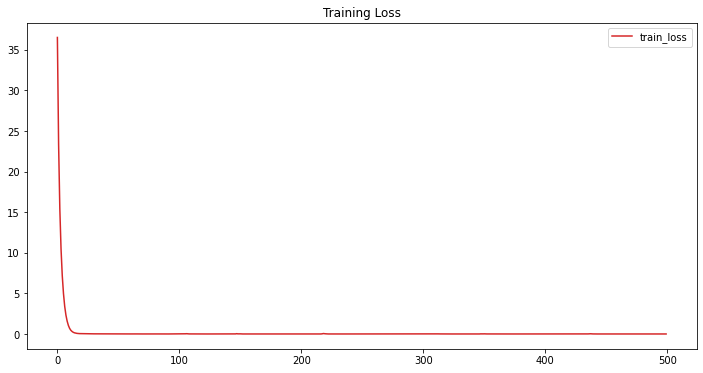

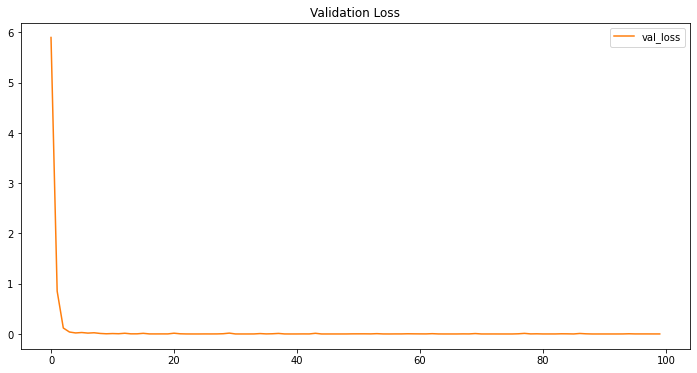

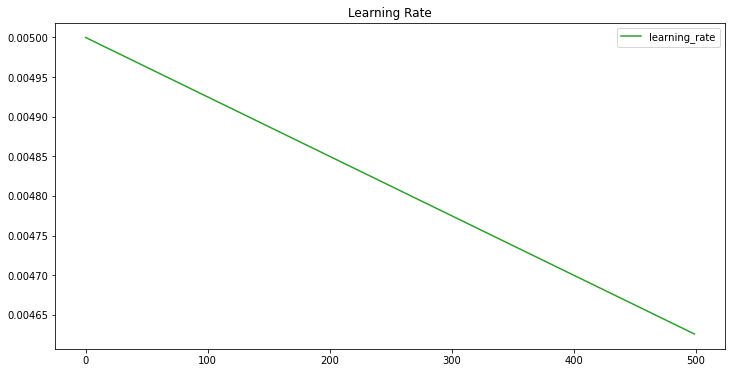

<class 'torch.nn.modules.rnn.LSTM'>
Start Training @ 2023-01-10 03:45:35.170468
Training samples: [995]
Training batches: [32]
Validation samples: [995]
Validation batches: [1]
-------------------------------------------
[*] Saved @ sample.rnn
-------------------------------------------
Final Training Loss: [0.00014635621209890814]
Final Validation Loss: [0.0001353856932837516]
End Training @ 2023-01-10 03:46:53.153731, Elapsed Time: [0:01:17.983263]


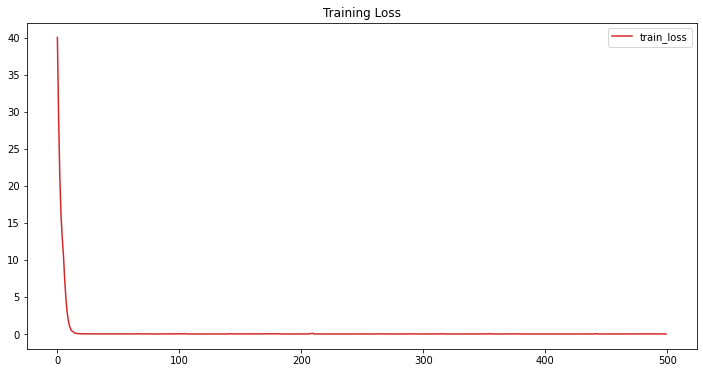

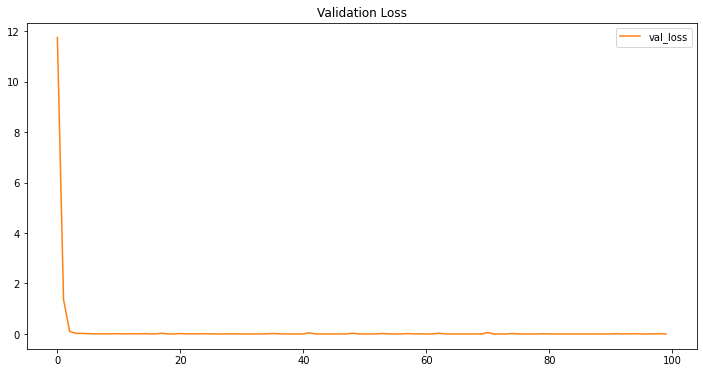

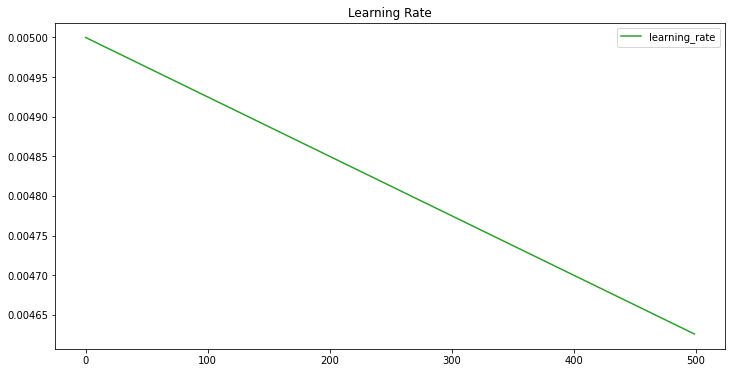

In [6]:
all_history={}
for rnm in rnms:
    print(rnm.rnn_class)
    history = kt.Trainer.train( rnm,
        training_data=ds, 
        validation_data=ds, 
        epochs=500, 
        batch_size=32, 
        shuffle=True, 
        validation_freq=5, 
        criterion_type=nn.MSELoss, 
        criterion_args={}, 
        optimizer_type=oo.Adam, 
        optimizer_args={'lr': 0.005, 'weight_decay': 0.0}, 
        lrs_type=oo.lr_scheduler.LinearLR, 
        lrs_args={'start_factor': 1.0, 'end_factor':0.7, 'total_iters': 2000},
        record_batch_loss=False, 
        early_stop_train=None,#kt.QuantiyMonitor('TrainLoss', patience=50, delta=0.00001, verbose=False), 
        early_stop_val=None, #kt.QuantiyMonitor('ValLoss', patience=50, delta=0.00001, verbose=False), 
        checkpoint_freq=5, 
        save_path='sample.rnn',
        save_state_only=True, 
        verbose=1, 
        plot=1
    )
    all_history[f'{rnm.rnn_class}'] = (history['loss'][-1], history['val_loss'][-1])
    print('=================================================')

<class 'known.ktorch.rnn.ELMAN'>:	(8.041860837693093e-05, 9.713353938423097e-05)
<class 'known.ktorch.rnn.GRU'>:	(0.00018171873807659722, 0.0003677874628920108)
<class 'known.ktorch.rnn.JANET'>:	(0.003072117873671232, 0.0017999777337536216)
<class 'known.ktorch.rnn.MGU'>:	(5.455531368170341e-05, 8.485127182211727e-05)
<class 'known.ktorch.rnn.LSTM'>:	(0.0021047866666776827, 0.009020145982503891)
<class 'torch.nn.modules.rnn.RNN'>:	(0.0013185231682655285, 0.0016052464488893747)
<class 'torch.nn.modules.rnn.GRU'>:	(0.0009644400906836381, 0.0007153996848501265)
<class 'torch.nn.modules.rnn.LSTM'>:	(0.00014635621209890814, 0.0001353856932837516)


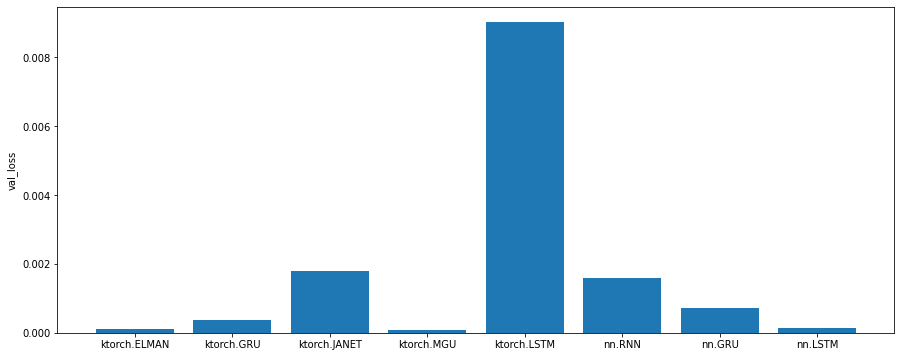

In [7]:
y = []
l = []
for k,v in all_history.items():
    print(f'{k}:\t{v}')
    y.append(v[1])
    sl = k.split('.')
    l.append(sl[1]+"."+sl[-1][:-2])

x= range(len(all_history))

plt.figure(figsize=(15,6))
plt.bar(x , y )
plt.xticks(x, l)
plt.ylabel('val_loss')
plt.show()

In [8]:
res = []
for rnm in rnms:
    print(rnm.rnn_class)
    rnm.eval()
    with tt.no_grad():
        for iv,(Xv,Yv) in enumerate(ds.dataloader(batch_size=len(ds)), 0):
            Pv = rnm(Xv)
            res.append(Pv)#print(Xv.shape, Yv.shape, Pv.shape)



<class 'known.ktorch.rnn.ELMAN'>
<class 'known.ktorch.rnn.GRU'>
<class 'known.ktorch.rnn.JANET'>
<class 'known.ktorch.rnn.MGU'>
<class 'known.ktorch.rnn.LSTM'>
<class 'torch.nn.modules.rnn.RNN'>
<class 'torch.nn.modules.rnn.GRU'>
<class 'torch.nn.modules.rnn.LSTM'>


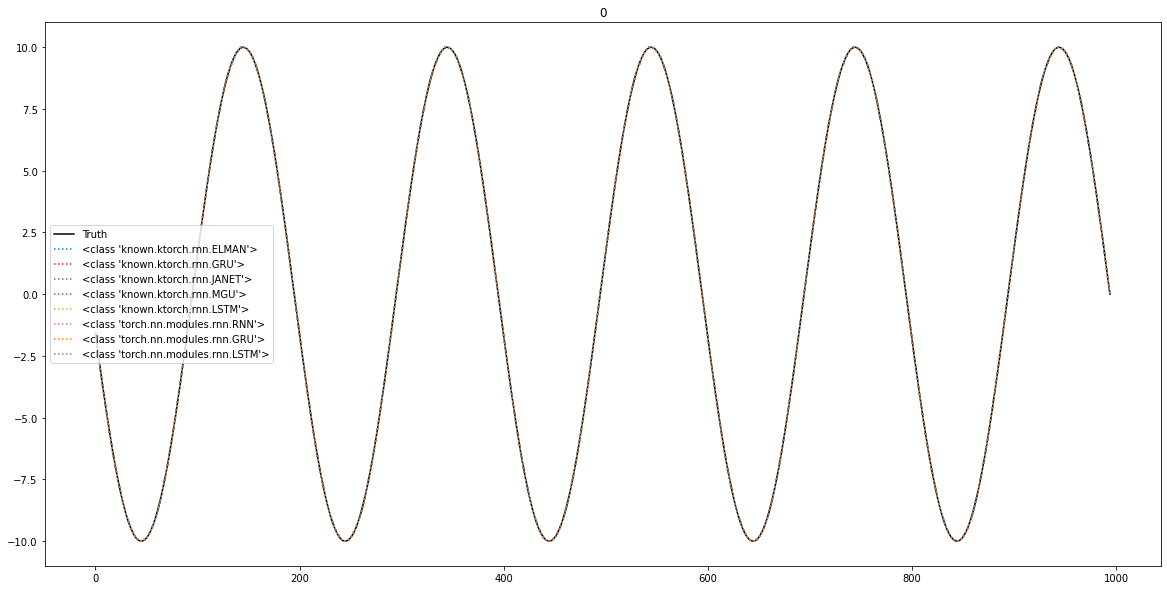

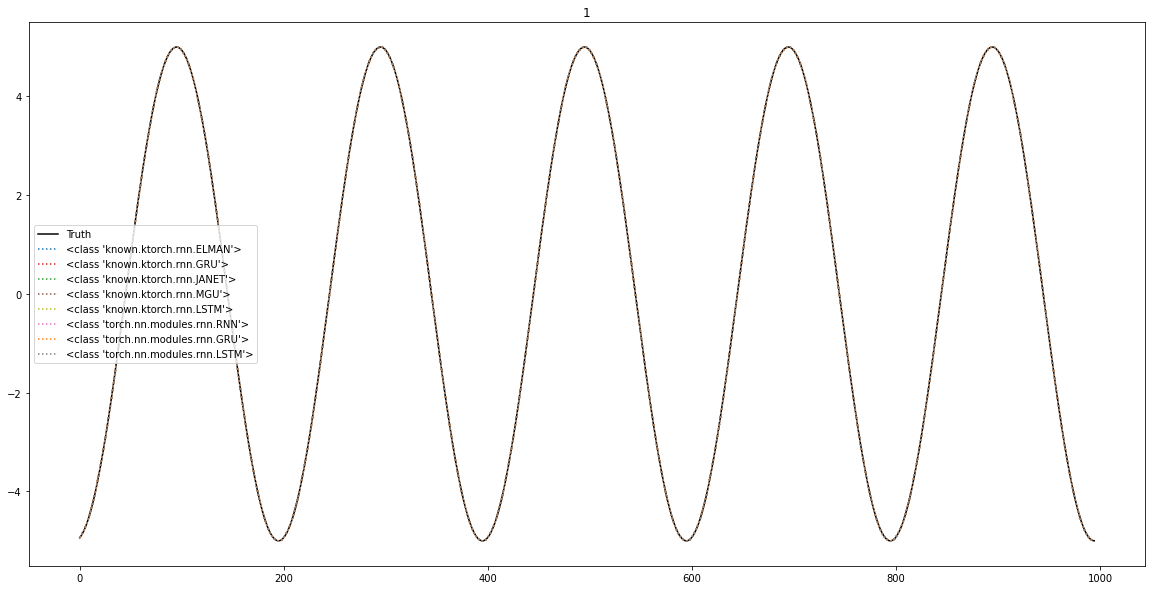

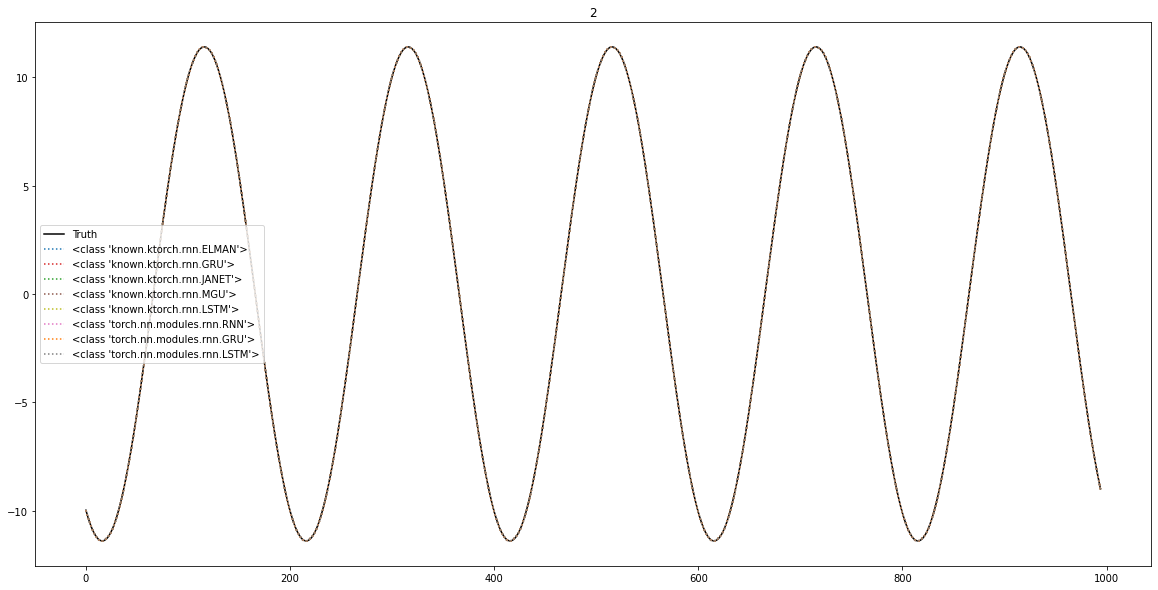

In [9]:
for i in range(input_size):
    plt.figure(figsize=(20,10))
    plt.title(f'{i}')
    
    plt.plot(Yv[:,i], color='black', label='Truth')
    for r,rnm,c in zip(res,rnms,rnmc):
        plt.plot(Pv[:,i], color=c, label=f'{rnm.rnn_class}', linestyle='dotted')
    plt.legend()
    plt.show()
    plt.close()
    print('=================================================')